In [1]:
import sys
from math import cos, pi
from pathlib import Path

import matplotlib.pyplot as plt

In [2]:
here = Path()
here.resolve()

PosixPath('/Users/mmitchel/Projects/GHEDesigner/notebooks/BTES')

In [3]:
root = here / ".." / ".."
root.resolve()

PosixPath('/Users/mmitchel/Projects/GHEDesigner')

In [4]:
sys.path.insert(0, str(root.resolve()))

In [5]:
from ghedesigner.ghe.manager import GroundHeatExchanger

In [6]:
def in_to_m(x):
    return x * 0.0254


def ft_to_m(x):
    return x * 0.3048

In [7]:
# borehole
d_b = in_to_m(5.5)
head_burial_depth = ft_to_m(6)

# 1-1/4" DR-11 HDPE pipe
d_po = in_to_m(1.66)
d_pi = in_to_m(1.34)
k_p = 0.4
rho_cp_p = 1542000
ss = (d_b - 2 * d_po) / 3
epsilon = 1e-6

# soil
k_s = 2.0
rho_cp_s = 2343493
ugt = 8

# grout
k_g = 1.4
rho_cp_g = 3901000

# fluid
fluid_name = "Water"
mean_fluid_temp = 10

# design/simulation params
num_design_months = 240
max_eft = 30
min_eft = 4
max_height = 300
min_height = 250
ghe_width = 400
ghe_length = 300
max_spacing = 6
min_spacing = 4
design_flow = 0.5

In [8]:
def run_ghed(loads, output_dir):
    ghe = GroundHeatExchanger()

    ghe.set_single_u_tube_pipe(
        inner_diameter=d_pi, outer_diameter=d_po, shank_spacing=ss, roughness=epsilon, conductivity=k_p, rho_cp=rho_cp_p
    )

    ghe.set_soil(conductivity=k_s, rho_cp=rho_cp_s, undisturbed_temp=ugt)

    ghe.set_grout(conductivity=k_g, rho_cp=rho_cp_g)

    ghe.set_fluid(fluid_name=fluid_name, temperature=mean_fluid_temp)

    ghe.set_borehole(buried_depth=head_burial_depth, diameter=d_b)

    ghe.set_simulation_parameters(num_months=num_design_months, max_boreholes=1500)

    ghe.set_ground_loads_from_hourly_list(loads)

    ghe.set_geometry_constraints_rectangle(
        length=ghe_length,
        width=ghe_width,
        b_min=min_spacing,
        b_max=max_spacing,
        min_height=min_height,
        max_height=max_height,
    )

    ghe.set_design(max_eft=max_eft, min_eft=min_eft, flow_rate=design_flow, flow_type_str="borehole")

    ghe.find_design()
    ghe.prepare_results("", "", "", "")
    ghe.write_output_files(output_dir)

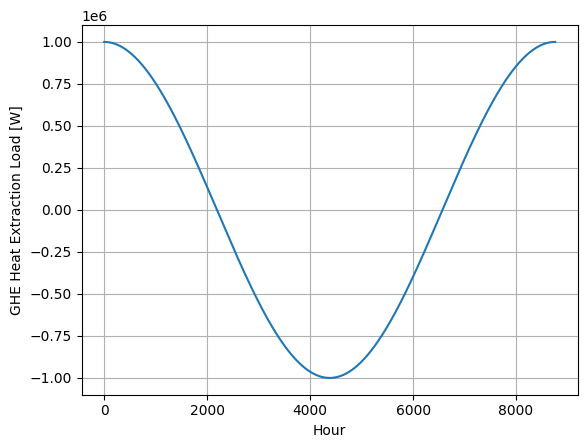

/Users/mmitchel/Projects/GHEDesigner/ghedesigner/ghe/ground_loads.py:614: UserWarning: A negative time step has been generated in the hybrid loading scheme. 
This will reduce the accuracy of the simulation.
  warnings.warn(warn_msg_neg_timestep)
/Users/mmitchel/Projects/GHEDesigner/ghedesigner/ghe/ground_loads.py:600: UserWarning: A negative time step has been generated in the hybrid loading scheme. 
This will reduce the accuracy of the simulation.
  warnings.warn(warn_msg_neg_timestep)
/Users/mmitchel/Projects/GHEDesigner/ghedesigner/ghe/ground_heat_exchangers.py:158: RuntimeWarning: invalid value encountered in log
  g_values = g(np.log((_time * SEC_IN_HR) / ts))


In [9]:
two_pi = 2 * pi
num_hr_in_year = 8760
amplitude = 1e6
loads = [amplitude * cos(x / num_hr_in_year * two_pi) for x in range(num_hr_in_year)]

fig, ax = plt.subplots()

ax.plot(loads)

ax.set_ylabel("GHE Heat Extraction Load [W]")
ax.set_xlabel("Hour")

plt.grid()
plt.show()

outdir = here / "out"

run_ghed(loads, outdir)